In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib import cm, colors

In [2]:
color2 = "#FF6F61"  # a vibrant coral
# color2 = "#88B04B"  # a fresh green
color1 = "#6B5B95"  # a rich purple

In [ ]:
from sympy import floor


fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(121, projection='3d')

rng = np.random.default_rng(114514)

nx = 13
ny = 13
x = np.arange(nx)
y = np.arange(ny)
dx = 1
dy = 0.25

x_sm = np.linspace(0, nx, 200)
y_sm = np.linspace(0, ny, 200)

rate = (1 + 4*np.exp(-((x-6)/1.5)**2/2))*5
rate_sm = (1 + 4*np.exp(-((x_sm-6)/1.5)**2/2))*5
counts = rng.poisson(lam=np.clip(rate, 0.5, None))
heights = counts.astype(float)

lam = 0.01
X, Y = np.meshgrid(x, y)
W = np.exp(-0.5*((X - Y)/lam)**2)
W = W / np.sum(W[:, int(nx/2)])
smoothed = W @ heights

W_sm = np.exp(-0.5*((x_sm[:, None] - y_sm[None, :])/1)**2)
W_sm = W_sm / np.sum(W_sm, axis=1, keepdims=True)
rate_sm_smoothed = W_sm @ rate_sm

# Bars
xpos = x - 0.5*dx
ypos = np.zeros_like(x)-0.8
zpos = np.zeros_like(x)
dz = heights
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=False, alpha=0.2, color=color1)

# Randomly scatter counts within each bin along x (within [x[i]-0.5, x[i]+0.5])
rng = np.random.default_rng(114514)  # use the same random seed for reproducibility
for i, count in enumerate(counts):
    if count > 0:
        xs = rng.uniform(x[i] - 0.5, x[i] + 0.5, count)
        # ys = rng.uniform(-0.8, -0.8 + dy, count)
        ys = np.full_like(xs, -0.8 + dy/2)  # align in the middle of the bar
        zs = np.arange(1, count + 1)
        ax.scatter(xs, ys, zs, color=color1, s=30, alpha=1, edgecolor=color1, linewidth=0.5)

# # Arrange counts within each bin in an ordered grid (along x, z, y fixed)
# for i, count in enumerate(counts):
#     if count > 0:
#         ncols = int(np.ceil(count/2))
#         nrows = int(np.ceil(count / ncols))
#         xs = np.linspace(x[i] - 0.16, x[i] + 0.16, nrows)
#         zs = np.linspace(1, count-1, ncols)
#         xs_grid, zs_grid = np.meshgrid(xs, zs)
#         xs_flat = xs_grid.flatten()[:count]
#         zs_flat = zs_grid.flatten()[:count]
#         ys_flat = np.full_like(xs_flat, -0.8)
#         ax.scatter(xs_flat, ys_flat, zs_flat, color=color1, s=30, alpha=1, edgecolor=color1, linewidth=0.5)
        
# yz bars
xpos_yz = np.zeros_like(y)-0.8
ypos_yz = y - 0.5 * dx
zpos_yz = np.zeros_like(y)
dx_yz = dy
dy_yz = dx
dz_yz = smoothed
ax.bar3d(xpos_yz, ypos_yz, zpos_yz, dx_yz, dy_yz, dz_yz, shade=False, alpha=0.4, color=color2)
x_curve = np.zeros_like(y_sm)  # place on the plane x≈0
ax.plot(x_curve, y_sm+0.25, rate_sm_smoothed, linewidth=4, color='r', linestyle='dashed')


# base tiles at slight negative z and zsort='min'
norm = colors.Normalize(vmin=np.min(W), vmax=np.max(W))
cmap = colors.LinearSegmentedColormap.from_list("black_blue_cyan", ["black", "blue", "cyan"])
z_base = -1e-3
for i in range(nx):
    for j in range(ny):
        quad = [
            [x[i] - 0.5, y[j] - 0.5, z_base],
            [x[i] + 0.5, y[j] - 0.5, z_base],
            [x[i] + 0.5, y[j] + 0.5, z_base],
            [x[i] - 0.5, y[j] + 0.5, z_base]
        ]
        rect = art3d.Poly3DCollection([quad])
        rect.set_facecolor(cmap(norm(W[j, i])))
        rect.set_edgecolor('#666666')
        rect.set_alpha(1)
        rect.set_linewidth(1)
        rect.set_zsort('min')
        ax.add_collection3d(rect)

# # red rectangle on top, lifted to z=0.2 and zsort='max'
# center_y = int(ny // 2)
# nonzero_x = np.where(W[center_y] > 0.05)[0]
# if nonzero_x.size > 0:
#     x_min = nonzero_x[0] - 0.5
#     x_max = nonzero_x[-1] + 0.5
#     y_min = center_y - 0.5
#     y_max = center_y + 0.5
#     z_rect = 0.2
#     rect2 = art3d.Poly3DCollection([
#         [
#             [x_min, y_min, z_rect],
#             [x_max, y_min, z_rect],
#             [x_max, y_max, z_rect],
#             [x_min, y_max, z_rect]
#         ]
#     ])
#     rect2.set_facecolor((1, 0, 0, 0.08))
#     rect2.set_edgecolor('red')
#     rect2.set_linewidth(3)
#     rect2.set_zsort('max')
#     ax.add_collection3d(rect2)

ax.set_xlabel("x (data bins)")
ax.set_ylabel("y (evaluation grid)")
ax.set_zlabel("I")
ax.view_init(elev=35, azim=45)
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_axis_off()
ax.grid(False)

# RHS plot with larger smoothing length
ax = fig.add_subplot(122, projection='3d')

lam = 1.35
X, Y = np.meshgrid(x, y)
W = np.exp(-0.5*((X - Y)/lam)**2)
W = W / np.sum(W[:, int(nx/2)])
smoothed = W @ heights

# Bars
xpos = x - 0.5*dx
ypos = np.zeros_like(x)-0.8
zpos = np.zeros_like(x)
dz = heights
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=False, alpha=0.2, color=color1)

# Randomly scatter counts within each bin along x (within [x[i]-0.5, x[i]+0.5])
rng = np.random.default_rng(114514)  # use the same random seed for reproducibility
for i, count in enumerate(counts):
    if count > 0:
        xs = rng.uniform(x[i] - 0.5, x[i] + 0.5, count)
        # ys = rng.uniform(-0.8, -0.8 + dy, count)
        ys = np.full_like(xs, -0.8 + dy/2)  # align in the middle of the bar
        zs = np.arange(1, count + 1)
        ax.scatter(xs, ys, zs, color=color1, s=30, alpha=1, edgecolor=color1, linewidth=0.5)
        
# add visual guide for kernel function on the left xz plane on the center bin
x_curve = np.linspace(-0.5, nx-0.5, 200)
y_curve = np.zeros_like(x_curve)-0.5
kernel_values = np.exp(-0.5 * ((x_curve - np.floor(ny/2)) / lam)**2)*10
# ax.plot(x_curve, y_curve, kernel_values, linewidth=4, color='b', linestyle='-', zorder=40)


# yz bars
xpos_yz = np.zeros_like(y)-0.8
ypos_yz = y - 0.5 * dx
zpos_yz = np.zeros_like(y)
dx_yz = dy
dy_yz = dx
dz_yz = smoothed
ax.bar3d(xpos_yz, ypos_yz, zpos_yz, dx_yz, dy_yz, dz_yz, shade=False, alpha=0.4, color=color2)
x_curve = np.zeros_like(y_sm)  # place on the plane x≈0
ax.plot(x_curve, y_sm+0.25, rate_sm_smoothed, linewidth=4, color='r', linestyle='dashed')

# base tiles at slight negative z and zsort='min'
norm = colors.Normalize(vmin=np.min(W), vmax=np.max(W))
cmap = colors.LinearSegmentedColormap.from_list("black_blue_cyan", ["black", "blue", "cyan"])
z_base = -1e-3
for i in range(nx):
    for j in range(ny):
        quad = [
            [x[i] - 0.5, y[j] - 0.5, z_base],
            [x[i] + 0.5, y[j] - 0.5, z_base],
            [x[i] + 0.5, y[j] + 0.5, z_base],
            [x[i] - 0.5, y[j] + 0.5, z_base]
        ]
        rect = art3d.Poly3DCollection([quad])
        rect.set_facecolor(cmap(norm(W[j, i])))
        rect.set_edgecolor('#666666')
        rect.set_alpha(1)
        rect.set_linewidth(1)
        rect.set_zsort('min')
        ax.add_collection3d(rect)

# # red rectangle on top, lifted to z=0.2 and zsort='max'
# center_y = int(ny // 2)
# nonzero_x = np.where(W[center_y] > 0.05)[0]
# if nonzero_x.size > 0:
#     x_min = nonzero_x[0] - 0.5
#     x_max = nonzero_x[-1] + 0.5
#     y_min = center_y - 0.5
#     y_max = center_y + 0.5
#     z_rect = 0.2
#     rect2 = art3d.Poly3DCollection([
#         [
#             [x_min, y_min, z_rect],
#             [x_max, y_min, z_rect],
#             [x_max, y_max, z_rect],
#             [x_min, y_max, z_rect]
#         ]
#     ])
#     rect2.set_facecolor((1, 0, 0, 0.08))
#     rect2.set_edgecolor('red')
#     rect2.set_linewidth(3)
#     rect2.set_zsort('max')
#     ax.add_collection3d(rect2)

ax.set_xlabel("x (data bins)")
ax.set_ylabel("y (evaluation grid)")
ax.set_zlabel("I")
ax.view_init(elev=35, azim=45)
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_axis_off()
ax.grid(False)
plt.tight_layout()

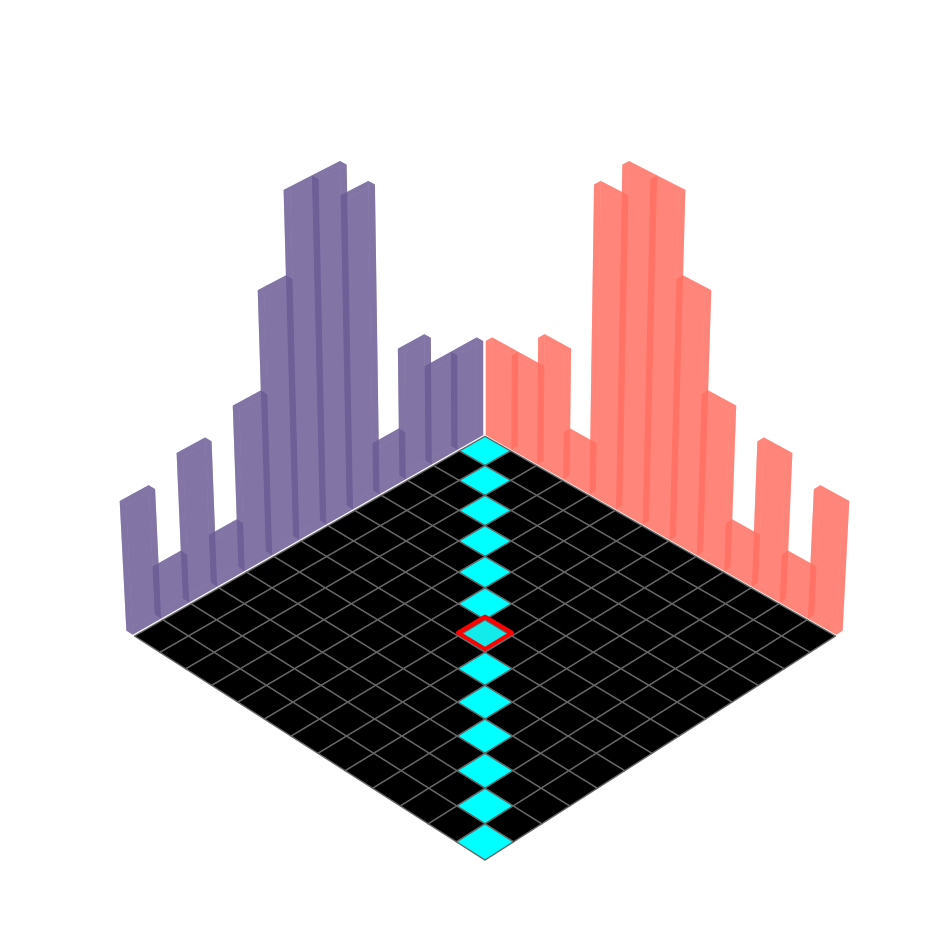

In [ ]:
rng = np.random.default_rng(7)

nx = 13
ny = 13
x = np.arange(nx)
y = np.arange(ny)
dx = 1
dy = 0.25

rate = (1 + 4*np.exp(-((x-6)/1.5)**2/2))*5
counts = rng.poisson(lam=np.clip(rate, 0.5, None))
heights = counts.astype(float)

lam = 0.01
X, Y = np.meshgrid(x, y)
W = np.exp(-0.5*((X - Y)/lam)**2)
W = W / np.sum(W[:, int(nx/2)])
smoothed = W @ heights

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Bars
xpos = x - 0.5*dx
ypos = np.zeros_like(x)-0.8
zpos = np.zeros_like(x)
dz = heights
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=False, alpha=0.6, color=color1)

# yz bars
xpos_yz = np.zeros_like(y)-0.8
ypos_yz = y - 0.5 * dx
zpos_yz = np.zeros_like(y)
dx_yz = dy
dy_yz = dx
dz_yz = smoothed
ax.bar3d(xpos_yz, ypos_yz, zpos_yz, dx_yz, dy_yz, dz_yz, shade=False, alpha=0.6, color=color2)

# base tiles at slight negative z and zsort='min'
norm = colors.Normalize(vmin=np.min(W), vmax=np.max(W))
cmap = colors.LinearSegmentedColormap.from_list("black_blue_cyan", ["black", "blue", "cyan"])
z_base = -1e-3
for i in range(nx):
    for j in range(ny):
        quad = [
            [x[i] - 0.5, y[j] - 0.5, z_base],
            [x[i] + 0.5, y[j] - 0.5, z_base],
            [x[i] + 0.5, y[j] + 0.5, z_base],
            [x[i] - 0.5, y[j] + 0.5, z_base]
        ]
        rect = art3d.Poly3DCollection([quad])
        rect.set_facecolor(cmap(norm(W[j, i])))
        rect.set_edgecolor('#666666')
        rect.set_alpha(1)
        rect.set_linewidth(1)
        rect.set_zsort('min')
        ax.add_collection3d(rect)

# red rectangle on top, lifted to z=0.2 and zsort='max'
center_y = int(ny // 2)
nonzero_x = np.where(W[center_y] > 0.05)[0]
if nonzero_x.size > 0:
    x_min = nonzero_x[0] - 0.5
    x_max = nonzero_x[-1] + 0.5
    y_min = center_y - 0.5
    y_max = center_y + 0.5
    z_rect = 0.2
    rect2 = art3d.Poly3DCollection([
        [
            [x_min, y_min, z_rect],
            [x_max, y_min, z_rect],
            [x_max, y_max, z_rect],
            [x_min, y_max, z_rect]
        ]
    ])
    rect2.set_facecolor((1, 0, 0, 0.08))
    rect2.set_edgecolor('red')
    rect2.set_linewidth(3)
    rect2.set_zsort('max')
    ax.add_collection3d(rect2)

ax.set_xlabel("x (data bins)")
ax.set_ylabel("y (evaluation grid)")
ax.set_zlabel("I")
ax.view_init(elev=35, azim=45)
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_axis_off()
ax.grid(False)